In [ ]:
from google.colab import files        #주피터 노트북에서 코드를 작성하여, 이 코드셀을 추가하였습니다.
src = list(files.upload().values())[0]
open('data_generator.py','wb').write(src)

Saving data_generator.py to data_generator.py


1789

number of classes:  4  sigma for data scatter: 1.0
generating training data
400 data points generated. Seed is random.


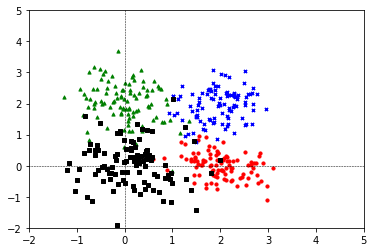

[[ 3.10478268e-01 -2.18146813e-01]
 [ 1.40872407e-01  7.91043490e-01]
 [-5.58524764e-01  5.19728406e-01]
 [-1.81187703e-01  1.71600890e-01]
 [-8.42167588e-01  3.99435775e-01]
 [-1.63698920e-01 -1.89570589e+00]
 [-2.20773014e-02  1.09179933e-01]
 [-6.12795772e-01  3.51679221e-01]
 [-4.62193455e-01 -5.06301085e-01]
 [ 4.00711483e-01 -5.27767078e-01]
 [ 1.75361065e-01  7.76629989e-01]
 [-1.39880816e-01 -5.88633248e-01]
 [-8.20168646e-01  1.58868152e+00]
 [-1.03264866e+00 -8.24748498e-01]
 [ 5.71526688e-01  1.11968584e+00]
 [ 1.28615317e+00 -4.36885158e-01]
 [ 9.11209360e-01 -2.99774445e-01]
 [ 1.26893010e+00  1.23146889e+00]
 [-1.20065940e+00 -1.52389227e-01]
 [-4.31022821e-01  4.02345199e-01]
 [ 3.32207922e-01 -9.16836630e-01]
 [-7.28153024e-01  7.06668110e-01]
 [-1.15855128e+00  8.64978647e-02]
 [-3.14760292e-01 -4.18220125e-01]
 [ 2.02446302e-01  1.54653299e-01]
 [ 6.12228426e-01 -2.60189009e-01]
 [-4.24044872e-01 -2.60635320e-02]
 [ 1.01625965e+00  2.14922092e+00]
 [ 5.11195036e-01  2

In [ ]:
'''
HW2 problem
'''

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.special as sp
import time
from scipy.optimize import minimize

import data_generator as dg

# you can define/use whatever functions to implememt

########################################
# Part 1. cross entropy loss
########################################
def cross_entropy_softmax_loss(Wb, x, y, num_class, n, feat_dim):
    # implement your function here
    # return cross entropy loss
    Wb = np.reshape(Wb, (-1, 1))  #W0에 따라 클래스가 3개면 (9,)짜리 나온다.
    b = Wb[-num_class:]
    W = np.reshape(Wb[range(num_class * feat_dim)], (num_class, feat_dim)) #Wb에서 클래스개수*데이터 차원 개수 만큼 weight 뽑음
    x=np.reshape(x.T, (-1, n))
    # this will give you a score matrix s of size (num_class)-by-(n)
    # the i-th column vector of s will be
    # the score vector of size (num_class)-by-1, for the i-th input data point
    #  performing s=Wx+b
    s=W@x+b
    softmaxLoss=0
    for i in range(len(s[0])):
       temp_sum=0
       for j in range(len(s)):
        temp_sum+=np.exp(s[j][i]) #s[[y[i]][i]는 정답 label
        
       softmaxLoss+=-np.log(np.exp(s[y[i]][i])/temp_sum)

      
    return softmaxLoss


########################################
# Part 2. SVM loss calculation
########################################
def svm_loss(Wb, x, y, num_class, n, feat_dim):
    # implement your function here
    # return SVM loss
    Wb = np.reshape(Wb, (-1, 1))  #W0에 따라 클래스가 3개면 (9,)짜리 나온다.
    b = Wb[-num_class:]
    W = np.reshape(Wb[range(num_class * feat_dim)], (num_class, feat_dim)) #Wb에서 클래스개수*데이터 차원 개수 만큼 weight 뽑음
    x=np.reshape(x.T, (-1, n))
    # this will give you a score matrix s of size (num_class)-by-(n)
    # the i-th column vector of s will be
    # the score vector of size (num_class)-by-1, for the i-th input data point
    #  performing s=Wx+b
    s=W@x+b
    SVMloss=0
    for i in range(len(s[0])):
      for j in range(len(s)):
        if j==y[i]:
          continue
        temp_sum=max(0,s[j][i]-s[y[i]][i]+1) #s[[y[i][i]]]는 정답 label
        SVMloss+=temp_sum
       
       

    return SVMloss/n
      


########################################
# Part 3. kNN classification
########################################
def knn_test(X_train, y_train, X_test, y_test, k):
    # implement your function here
    #return accuracy
    train_num=X_train.shape[0]
    test_num=X_test.shape[0]

    dist_matrix=np.sum(X_train**2,axis=1)[:,np.newaxis]+np.sum(X_test**2,axis=1)[:,np.newaxis].T-2*np.dot(X_train,X_test.T) #np.sum하면 다 1차원배열로 결과가 나옴
    predict,_ =stats.mode(y_train[np.argsort(dist_matrix,axis=0)[range(k),:]])
    accuracy=np.sum(np.reshape(predict,(-1,))==np.reshape(y_test,(-1,)))/test_num
    return accuracy


# now lets test the model for linear models, that is, SVM and softmax
def linear_classifier_test(Wb, x, y, num_class):
    n_test = x.shape[0]
    feat_dim = x.shape[1]
    
    Wb = np.reshape(Wb, (-1, 1)) #W0에 따라 클래스가 3개면 (9,)짜리 나온다.이게 (9,1)로 바뀜
    b = Wb[-num_class:].squeeze() #squeeze()는 1차원으로 축소, Wb는 reshape로 인해 (클래스개수,1) 차원이었음
    W = np.reshape(Wb[:-num_class], (num_class, feat_dim)) #Wb[:-num_class]는 Wb의 처음부터 -num_class번째까지, 클래스가 3개면 w0에 따라서 (6,1)짜리 벡터 만들졌다가, (3,2)로 reshpae 
    accuracy = 0

    # W has shape (num_class, feat_dim), b has shape (num_class,)

    # score
    s = x@W.T + b
    # score has shape (n_test, num_class)
    
    # get argmax over class dim
    res = np.argmax(s, axis = 1)

    # get accuracy
    accuracy = (res == y).astype('uint8').sum()/n_test
    
    return accuracy


"""def knn_test(X_train, y_train, X_test, y_test, k):
    n_train_sample = X_train.shape[0]
    n_test_sample  = X_test.shape[0]

    dist_mat = np.sum(X_train ** 2, axis=1)[:, np.newaxis] + (np.sum(X_test ** 2, axis=1)[:, np.newaxis]).T \ #
               - 2 * np.dot(np.reshape(X_train, (n_train_sample, -1)), np.reshape(X_test, (n_test_sample, -1)).T)

    # choose most frequent index
    predicted_labels, _ = stats.mode(y_train[np.argsort(dist_mat, axis=0)[range(k), :]]) #argsort는 인덱스를 결과값으로 출력함.따라서 거리가 가장작은 순으로 인덱스 나옴,
                                                                                         # stats mode는 열을 기준으로 가장 보편적인 값 반환함.     
    accuracy = np.sum(np.reshape(predicted_labels, (-1,)) == y_test.reshape(-1, )) / n_test_sample
    return accuracy"""



# number of classes: this can be either 3 or 4
num_class = 4

# sigma controls the degree of data scattering. Larger sigma gives larger scatter
# default is 1.0. Accuracy becomes lower with larger sigma
sigma = 1.0

print('number of classes: ',num_class,' sigma for data scatter:',sigma)
if num_class == 4:
    n_train = 400
    n_test = 100
    feat_dim = 2
else:  # then 3
    n_train = 300
    n_test = 60
    feat_dim = 2

# generate train dataset
print('generating training data')
x_train, y_train = dg.generate(number=n_train, seed=None, plot=True, num_class=num_class, sigma=sigma)
print(x_train)

print(y_train)

# generate test dataset
print('generating test data')
x_test, y_test = dg.generate(number=n_test, seed=None, plot=False, num_class=num_class, sigma=sigma)

# set classifiers to 'svm' to test SVM classifier
# set classifiers to 'softmax' to test softmax classifier
# set classifiers to 'knn' to test kNN classifier
classifiers = 'knn'

if classifiers == 'svm':
    print('training SVM classifier...')
    w0 = np.random.normal(0, 1, (2 * num_class + num_class)) #왜 여기서 2*num_class로 설정했을까? 데이터 크기가 2여서??
    result = minimize(svm_loss, w0, args=(x_train, y_train, num_class, n_train, feat_dim)) #svm_loss의 최적화되는 Wb찾는다. args가 x_train, y_train, num_class, n_train,feat_dim이기 때문에 남은게 Wb이므로, Wb를 변수로??..x_train~feat_dim은 여기서 숫자로 들어감(고정됨).
    print('testing SVM classifier...')

    Wb = result.x
    print('accuracy of SVM loss: ', linear_classifier_test(Wb, x_test, y_test, num_class)*100,'%')

elif classifiers == 'softmax':
    print('training softmax classifier...')
    w0 = np.random.normal(0, 1, (2 * num_class + num_class)) #np.random.normal(평균,표준편차,개수)
    result = minimize(cross_entropy_softmax_loss, w0, args=(x_train, y_train, num_class, n_train, feat_dim)) #

    print('testing softmax classifier...')

    Wb = result.x
    print('accuracy of softmax loss: ', linear_classifier_test(Wb, x_test, y_test, num_class)*100,'%')

else:  # knn
    # k value for kNN classifier. k can be either 1 or 3.
    k = 3
    print('testing kNN classifier...')
    print('accuracy of kNN loss: ', knn_test(x_train, y_train, x_test, y_test, k)*100
          , '% for k value of ', k)